# Convolutional LSTM for time series forecasting

## Imports

In [1]:
from utilities.std_imports import *
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow.keras as tk

## Utilities

In [25]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
                
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

def forecast(model, history, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #flatten
    input_x = data[-n_input:, 0] # retrieve last observations for input data
    input_x = input_x.reshape((1, len(input_x), 1)) # reshape into [1, n_input, 1]
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhatdef evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
def evaluate_model(train, test, n_input):
    model = build_model(train, n_input)
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :]) # get real observation and add to history for predicting the next week
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# plot scores
def plot_scores(scores):
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    pyplot.plot(days, scores, marker='o', label='lstm')
    pyplot.show()
    

## Load and preprocess data

In [9]:
ds = pd.read_csv('D:/data/csv/power_consumption.csv', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
ds.replace('?', np.nan, inplace=True)
ds = ds.astype('float32')
fill_missing(ds.values)
values = ds.values
ds['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6]) #remainder of submetering
ds.to_csv('D:/data/csv/household_power_consumption.csv')
ds.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.099998


#### Daily grouping

In [17]:
ds = pd.read_csv('D:/data/csv/household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
daily_groups = ds.resample('D')
daily = daily_groups.sum()
daily.to_csv('D:/data/csv/household_power_consumption_days.csv')
print(daily.shape)
daily.head()

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


#### Split into standard weeks

In [18]:
dataset = pd.read_csv('D:/data/csv/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


## LSTM Model With Univariate Input and Vector Output

## univariate multi-step lstm
1. split_dataset : Split train/test
2. evaluate_forecasts : Evaluate forecasts against expected values
3. summarize_scores : Summarize scores
4. to_supervised : Convert history into inputs and outputs
5. build_model : Build and train the model
6. forecast : Make a forecast
7. evaluate_model : evaluate a single model

#### Function definitions

In [19]:
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) #flatten
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return np.array(X), np.array(y)

def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = tk.models.Sequential()
    model.add(tk.layers.LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(tk.layers.Dense(100, activation='relu'))
    model.add(tk.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

#### Testing

lstm: [408.876] 411.4, 417.0, 398.8, 424.5, 407.5, 326.8, 463.7


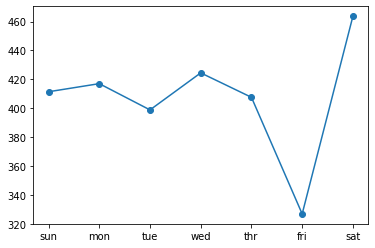

In [26]:
ds = pd.read_csv('D:/data/csv/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(ds.values)
score, scores = evaluate_model(train, test, n_input=7)
summarize_scores('lstm', score, scores)
plot_scores(scores)

## Encoder-decoder LSTM univariate

#### Function definitions

In [31]:
def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = tk.models.Sequential()
    model.add(tk.layers.LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(tk.layers.RepeatVector(n_outputs))
    model.add(tk.layers.LSTM(200, activation='relu', return_sequences=True))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(100, activation='relu')))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

#### Testing

In [32]:
score, scores = evaluate_model(train, test, n_input=14)
summarize_scores('lstm', score, scores)
plot_scores(scores)

## Encoder-Decoder LSTM Model With Multivariate Input

#### Function definitions

In [37]:
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return np.array(X), np.array(y)
 
def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = tk.models.Sequential()
    model.add(tk.layers.LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(tk.layers.RepeatVector(n_outputs))
    model.add(tk.layers.LSTM(200, activation='relu', return_sequences=True))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(100, activation='relu')))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

#### Testing

In [38]:
score, scores = evaluate_model(train, test, n_input=14)
summarize_scores('lstm', score, scores)
plot_scores(scores)

lstm: [381.372] 390.0, 371.1, 341.1, 402.3, 354.9, 312.3, 476.1


## CNN-LSTM Encoder-Decoder Model With Univariate Input

#### Function definitions

In [44]:
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return np.array(X), np.array(y)

def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = tk.models.Sequential()
    model.add(tk.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(tk.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tk.layers.MaxPooling1D(pool_size=2))
    model.add(tk.layers.Flatten())
    model.add(tk.layers.RepeatVector(n_outputs))
    model.add(tk.layers.LSTM(200, activation='relu', return_sequences=True))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(100, activation='relu')))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

#### Testing

In [45]:
dataset = pd.read_csv('D:/data/csv/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)

In [46]:
score, scores = evaluate_model(train, test, n_input=14)
summarize_scores('lstm', score, scores)
plot_scores(scores)

lstm: [374.315] 378.6, 393.7, 339.8, 364.6, 375.4, 324.2, 433.5


## ConvLSTM univariate Encoder-Decoder Model With Multivariate Input

#### Function definitions

In [58]:
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, :]
            x_input = x_input.reshape((len(x_input), -1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return np.array(X), np.array(y)

def build_model(train, n_steps, n_length, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = tk.models.Sequential()
    model.add(tk.layers.ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(tk.layers.Flatten())
    model.add(tk.layers.RepeatVector(n_outputs))
    model.add(tk.layers.LSTM(200, activation='relu', return_sequences=True))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(100, activation='relu')))
    model.add(tk.layers.TimeDistributed(tk.layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

def forecast(model, history, n_steps, n_length, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_steps, 1, n_length, input_x.shape[1]))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

def evaluate_model(train, test, n_steps, n_length, n_input):
    model = build_model(train, n_steps, n_length, n_input)
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

#### Testing

In [59]:
dataset = pd.read_csv('D:/data/csv/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)

In [60]:
score, scores = evaluate_model(train, test, n_steps=2, n_length=7, n_input=2*7)
summarize_scores('lstm', score, scores)
plot_scores(scores)

lstm: [394.721] 431.6, 429.2, 331.1, 389.7, 391.0, 353.2, 425.5


## Credits & Links

https://www.kaggle.com/kcostya/lstm-models-for-multi-step-time-series-forecast